## ARCH and GARCH Models

https://github.com/bashtage/arch Package NB

In [83]:
! pip install arch

In [84]:
import arch
from arch import arch_model
from arch.univariate import GARCH
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import sys
from matplotlib.dates import DateFormatter
from scipy.stats import invweibull
from arch.univariate import ARX # autoregressive model on max loss returns, 1 3, 12 lags
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

sys.path.append("/home/jovyan/data_warehouse/")
from dw_src.api.features_api import get_features_df, load_features

### Prep Data

In [3]:
# High Frequency Data
features_to_load = [
    "midprice_mean",
    "traded_price_mean"

]

# Last 2 weeks
end_date = datetime.datetime.now(datetime.timezone.utc)
start_date = end_date - datetime.timedelta(days=7)

# Choose buckketing
time_agg = "30sec" # 1sec/5sec/10sec/30sec/60sec

high_freq= load_features(
    "ftx", "BTCUSDP", time_agg, start_date, end_date, features_to_load
)
high_freq.to_csv("1Min_BTCUSDP_March23_30.csv")

/opt/conda/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Query complete after 0.20s: 100%|██████████| 3/3 [00:00<00:00, 15.23query/s]                                  
/opt/conda/lib/python3.8/site-packages/google/cloud/bigquery/client.py:444: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(
Downloading: 100%|██████████| 18424/18424 [00:00<00:00, 19444.34rows/s]


In [32]:

high_freq=high_freq[:15000]

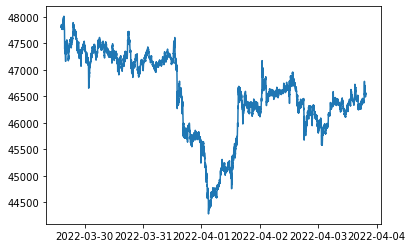

In [33]:
plt.plot(high_freq['midprice_mean'])

<ipython-input-34-0f9214f81b6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_freq['return']=100 * high_freq['midprice_mean'].pct_change()


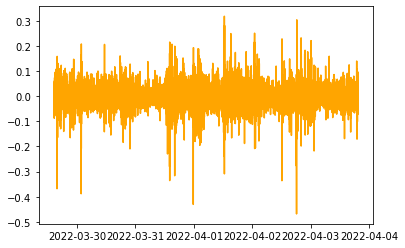

In [34]:
high_freq['return']=100 * high_freq['midprice_mean'].pct_change()
plt.plot(high_freq['return'].dropna(),color='orange')

In [35]:
high_freq

,exchange,symbol,midprice_mean,traded_price_mean,return,max_loss
timestamp,,,,,,
2022-03-29 14:28:00+00:00,ftx,BTCUSDP,47807.707487,47808.803636,NaN,-0.000000
2022-03-29 14:28:30+00:00,ftx,BTCUSDP,47806.831853,47807.507353,-0.001832,0.001832
2022-03-29 14:29:00+00:00,ftx,BTCUSDP,47790.650402,47792.123967,-0.033848,0.033848
2022-03-29 14:29:30+00:00,ftx,BTCUSDP,47812.091603,47822.873494,0.044865,0.033848
2022-03-29 14:30:00+00:00,ftx,BTCUSDP,47801.952953,47807.531034,-0.021205,0.033848
...,...,...,...,...,...,...
2022-04-03 19:25:30+00:00,ftx,BTCUSDP,46563.343054,46562.119048,0.039115,0.058851
2022-04-03 19:26:00+00:00,ftx,BTCUSDP,46561.817726,46562.085470,-0.003276,0.058851
2022-04-03 19:26:30+00:00,ftx,BTCUSDP,46559.486275,46558.100000,-0.005007,0.058851


In [36]:
def generate_max(series): 
    '''
    Here is largest  loss for  last 5 minute returns (1 min increments) excluding nan values 
    
    '''
    max_values=np.array([])
    for i,x in enumerate(series.values):
        if np.isnan(series.values[i]):
            max_values=np.append(max_values,0)
            j=i
            continue
            
        max_values=np.append(max_values,min(series.values[max(j+1,i-9):i+1]))
 
    max_series=pd.Series(max_values,index=series.index)
    return -max_series # view losses as positive

In [37]:
high_freq['max_loss']=max_series=generate_max(high_freq['return'])

<ipython-input-37-09254c662f25>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_freq['max_loss']=max_series=generate_max(high_freq['return'])


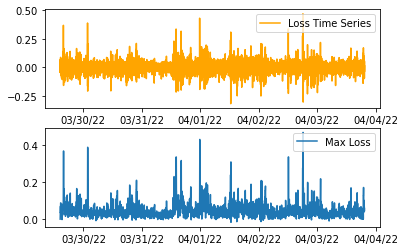

In [38]:
fig,ax = plt.subplots(2,1)


ax[1].plot(high_freq['max_loss'], label='Max Loss')
ax[0].plot(-high_freq['return'], label='Loss Time Series',color='orange') # flip returns to view
ax[0].legend()
ax[1].legend()
ax[0].xaxis.set_major_formatter(DateFormatter("%D"))
ax[1].xaxis.set_major_formatter(DateFormatter("%D"))

In [39]:
high_freq

,exchange,symbol,midprice_mean,traded_price_mean,return,max_loss
timestamp,,,,,,
2022-03-29 14:28:00+00:00,ftx,BTCUSDP,47807.707487,47808.803636,NaN,-0.000000
2022-03-29 14:28:30+00:00,ftx,BTCUSDP,47806.831853,47807.507353,-0.001832,0.001832
2022-03-29 14:29:00+00:00,ftx,BTCUSDP,47790.650402,47792.123967,-0.033848,0.033848
2022-03-29 14:29:30+00:00,ftx,BTCUSDP,47812.091603,47822.873494,0.044865,0.033848
2022-03-29 14:30:00+00:00,ftx,BTCUSDP,47801.952953,47807.531034,-0.021205,0.033848
...,...,...,...,...,...,...
2022-04-03 19:25:30+00:00,ftx,BTCUSDP,46563.343054,46562.119048,0.039115,0.058851
2022-04-03 19:26:00+00:00,ftx,BTCUSDP,46561.817726,46562.085470,-0.003276,0.058851
2022-04-03 19:26:30+00:00,ftx,BTCUSDP,46559.486275,46558.100000,-0.005007,0.058851


## Fitting a Frechet / Inverse Weibull Dist 

In [40]:
global_shape,global_loc,global_scale=invweibull.fit(high_freq['max_loss'][:10000])
global_shape,global_loc,global_scale

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(6.742460906248059, -0.13033346715968025, 0.17241578790914258)

No handles with labels found to put in legend.


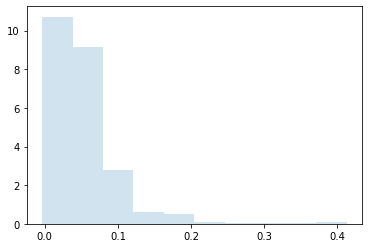

In [54]:
r = invweibull.rvs(global_shape,loc=global_loc,scale=global_scale, size=10000)
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)
plt.legend(loc='best', frameon=False)
plt.show()

## Empirical Data

No handles with labels found to put in legend.


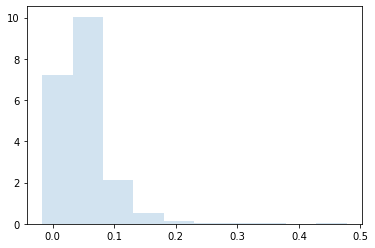

In [55]:
plt.hist(high_freq['max_loss'][:10000], density=True, histtype='stepfilled', alpha=0.2)
plt.legend(loc='best', frameon=False)
plt.show()

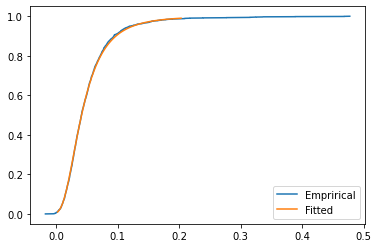

In [68]:
### Comparing Static distributions
ecdf=ECDF(high_freq['max_loss'][:10000])
plt.plot(ecdf.x,ecdf.y,label='Emprirical')

n=100
x = np.linspace(invweibull.ppf(0.01, global_shape,loc=global_loc,scale=global_scale),
                invweibull.ppf(0.99, global_shape,loc=global_loc,scale=global_scale), n)
frechet_cdf=invweibull.cdf(x,global_shape,loc=global_loc,scale=global_scale)
plt.plot(x,frechet_cdf,label='Fitted')
plt.legend()


**Notes**
- Exhibited is empirical pdf and cdf against the fitted frechet distribution off global trained loc/scale/shape parameters
- This is a static approach, no time varying is incorporated

# Incorporating time varying parameters 

### Train Data ->
- First 10000 Samples
- Very time intensive do not rerun frequently


In [41]:
#k= 5000 # num samples

#shape_vals=pd.Series([])
#loc_vals=pd.Series([])
#scale_vals=pd.Series([])
#time_vary=high_freq[10000:10000+k]
#i=0
#for x, row in high_freq[10000:10000+k].iterrows():
    
 #   shape,loc,scale=invweibull.fit(high_freq['max_loss'].values[:10000+i],floc=global_loc)
    
  #  shape_vals=shape_vals.append(pd.Series([shape],index=[x]))
  #  loc_vals=loc_vals.append(pd.Series([loc],index=[x]))
   # scale_vals=scale_vals.append(pd.Series([scale],index=[x]))
   # i=i+1
        
#time_vary['shape']=shape_vals
#time_vary['loc']=loc_vals
#time_vary['scale']=scale_vals
#time_vary.to_csv('time_vary.csv')

<ipython-input-41-f1a48e0c6535>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  shape_vals=pd.Series([])
<ipython-input-41-f1a48e0c6535>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  loc_vals=pd.Series([])
<ipython-input-41-f1a48e0c6535>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scale_vals=pd.Series([])
<ipython-input-41-f1a48e0c6535>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

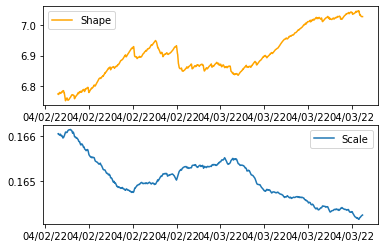

In [42]:
fig,ax = plt.subplots(2,1)


ax[1].plot(time_vary['scale'], label='Scale')
ax[0].plot(time_vary['shape'], label='Shape',color='orange') # flip returns to view
ax[0].legend()
ax[1].legend()
ax[0].xaxis.set_major_formatter(DateFormatter("%D"))
ax[1].xaxis.set_major_formatter(DateFormatter("%D"))

### Precalibrated data for Time varying parameters

In [44]:
arc_model=pd.read_csv('time_vary.csv')
arc_model

,timestamp,exchange,symbol,midprice_mean,traded_price_mean,return,max_loss,shape,loc,scale
0,2022-04-02 01:48:00+00:00,ftx,BTCUSDP,46733.855967,46731.271357,0.020355,0.036762,6.772763,-0.130333,0.166050
1,2022-04-02 01:48:30+00:00,ftx,BTCUSDP,46756.950170,46756.168421,0.049416,0.036762,6.773214,-0.130333,0.166050
2,2022-04-02 01:49:00+00:00,ftx,BTCUSDP,46763.303129,46763.333333,0.013587,0.036762,6.773641,-0.130333,0.166049
3,2022-04-02 01:49:30+00:00,ftx,BTCUSDP,46789.687500,46790.272727,0.056421,0.015684,6.773955,-0.130333,0.166049
4,2022-04-02 01:50:00+00:00,ftx,BTCUSDP,46799.601852,46800.934959,0.021189,-0.005961,6.774138,-0.130333,0.166045
...,...,...,...,...,...,...,...,...,...,...
4995,2022-04-03 19:25:30+00:00,ftx,BTCUSDP,46563.343054,46562.119048,0.039115,0.058851,7.029150,-0.130333,0.164230
4996,2022-04-03 19:26:00+00:00,ftx,BTCUSDP,46561.817726,46562.085470,-0.003276,0.058851,7.029230,-0.130333,0.164231
4997,2022-04-03 19:26:30+00:00,ftx,BTCUSDP,46559.486275,46558.100000,-0.005007,0.058851,7.029202,-0.130333,0.164233
4998,2022-04-03 19:27:00+00:00,ftx,BTCUSDP,46563.019011,46564.018519,0.007588,0.058851,7.029242,-0.130333,0.164233


In [81]:
exog=-arc_model['max_loss']
## having isssues estimating parameter on max_loss
## look-ahead bias 

In [82]:
mod = AutoReg(arc_model['shape'],1,trend='c',exog=np.exp(exog))
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                  shape   No. Observations:                 5000
Model:                   AutoReg-X(1)   Log Likelihood               32840.685
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Tue, 05 Apr 2022   AIC                            -15.975
Time:                        16:06:00   BIC                            -15.970
Sample:                             1   HQIC                           -15.973
                                 5000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0072      0.000    -16.392      0.000      -0.008      -0.006
shape.L1       1.0000    6.1e-05   1.64e+04      0.000       1.000       1.000
max_loss       0.0075      0.000     55.579      0.0

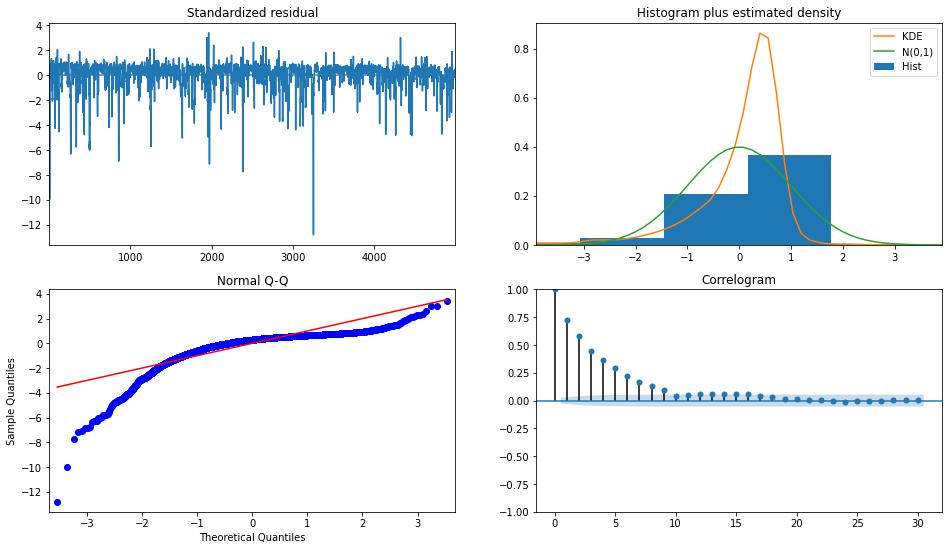

In [77]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

# Standardized residual shows non-explained by model
# Estimated density against N(0,1)
# Correlogram shows acf function 

In [69]:
mod = AutoReg(arc_model['scale'],1,trend='c',exog=exog)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                  scale   No. Observations:                 5000
Model:                   AutoReg-X(1)   Log Likelihood               60606.544
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Tue, 05 Apr 2022   AIC                            -27.084
Time:                        15:54:21   BIC                            -27.079
Sample:                             1   HQIC                           -27.082
                                 5000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.432e-05   6.43e-06     13.121      0.000    7.17e-05    9.69e-05
scale.L1       0.9997   3.88e-05   2.58e+04      0.000       1.000       1.000
max_loss   -4.414e-05   5.21e-07    -84.740      0.0

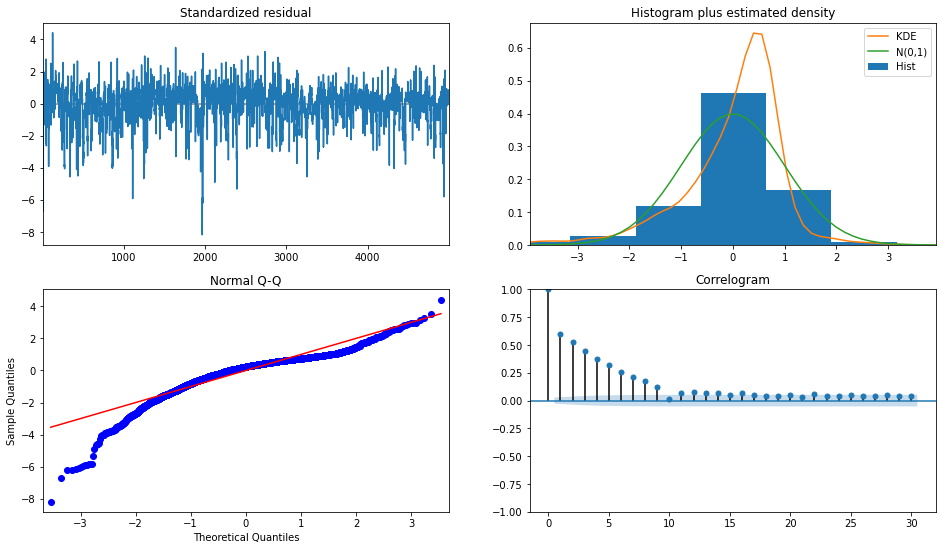

In [70]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

# Standardized residual shows non-explained by model
# Estimated density against N(0,1)
# Correlogram shows acf function 

## CVAR Estiamtion and Analysis

## Scale Parameter comparison to GARCH on Midprice Series

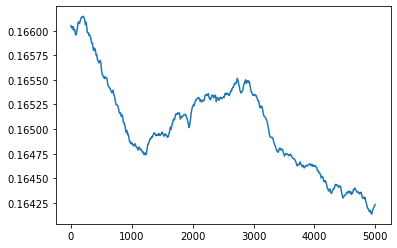

In [85]:
plt.plot(arc_model['scale'])

In [106]:
am = arch_model(arc_model['return'],rescale=True)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 988.478869411273
Iteration:     10,   Func. Count:     62,   Neg. LLF: 958.1683293836495
Optimization terminated successfully    (Exit mode 0)
            Current function value: 958.168042663275
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -958.168
Distribution:                  Normal   AIC:                           1924.34
Method:            Maximum Likelihood   BIC:                           1950.40
                                        No. Observations:                 5000
Date:                Tue, Apr 05 2022   Df Residuals:                     4999
Time:            

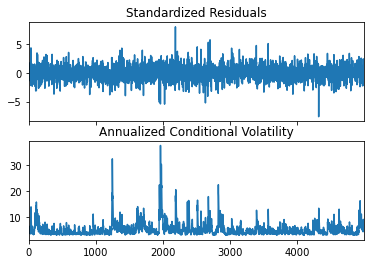

In [107]:
fig = res.plot(annualize="D")